In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, f1_score, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, plot_precision_recall_curve, classification_report, precision_score, recall_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

В [задаче](https://www.kaggle.com/c/tabular-playground-series-apr-2021) рассматривается синтетический набор данных, созданный по мотивам [оригинального](https://www.kaggle.com/c/titanic) соревнования 'Титаник'. Данный 'дадасет' сгенерирован таким образом, что нет способа 'обмануть' модель, используя общедоступные метки, как это было в оригинальном соревновании.
Задача - предсказать, выжил ли пассажир после крушения 'Титаника'. Для каждого PasengerId, нужно предсказать значение 0 или 1 (бинарная классификация). Метрика используемая для оценки качества модели - Accuracy (доля верных ответов).
$$\large accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$



# Features
***
|Переменная|Определение|Значения|
|:----------|:---------|:-----|
|Survived|Выживание|(0 = Нет, 1 = Да)|
|Pclass|Класс билета|(1 = 1st, 2 = 2nd, 3 = 3rd)|
|Sex|Пол|
|Age|Возраст в годах|
|SibSp|# Братьев и сестер/супругов на борту "Титаника"|
|Parch|# Родителей/детей на борту "Титаника"|	
|Ticket|Номер билета|
|Fare|Пассажирский тариф (стоимость)|  	
|Cabin|Номер каюты|
|Embarked|Порт отправления|(C = Cherbourg, Q = Queenstown, S = Southampton)|

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
# объединение test и train
data = train.append(test, ignore_index=True)

# Exploratory data analysis

## 1. Data visualization: First Overview

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


В дадасете есть как числовые, так и категориальные признаки, также есть пропущенные значения.

## 1.1 Target Variable

In [4]:
# seaborn style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16,6)

<Figure size 432x288 with 0 Axes>

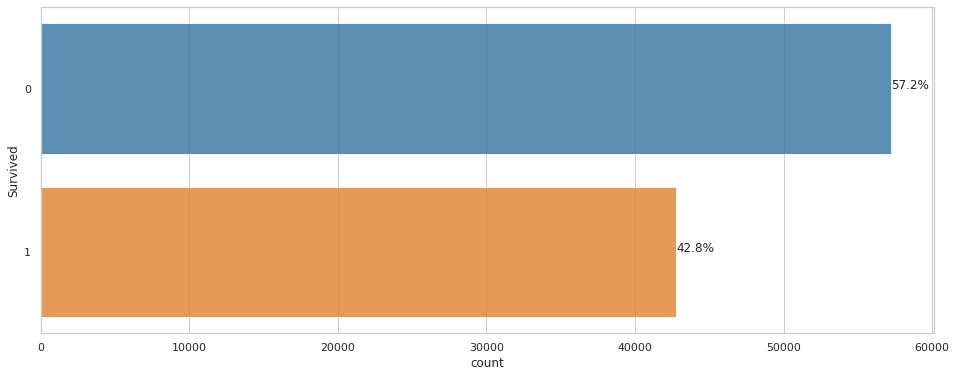

In [5]:
ax = sns.countplot(y='Survived', data=train, alpha=0.8)
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

Классы в тренировачной выборке можно считать сбалансированными.

## 1.2 Data missings

In [6]:
# строим таблицу пропущенных значений в данных
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(11)

,Total,Percent
Cabin,67866,0.67866
Ticket,4623,0.04623
Age,3292,0.03292
Embarked,250,0.00250
Fare,134,0.00134
Parch,0,0.00000
SibSp,0,0.00000
Sex,0,0.00000
Name,0,0.00000
Pclass,0,0.00000


Из таблицы видно, что признак 'Cabin' имеет почти 70% пропущенных значений. В остальных признаках, пропуски не так критичны.

## 1.3 Numerical features

Посмотрим на распределение вещественных признаков, в нашем случае это 'Age' и 'Fare'.

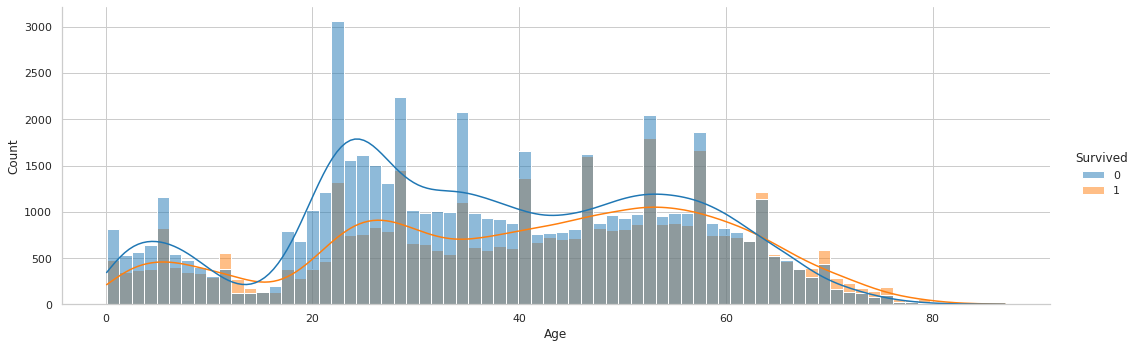

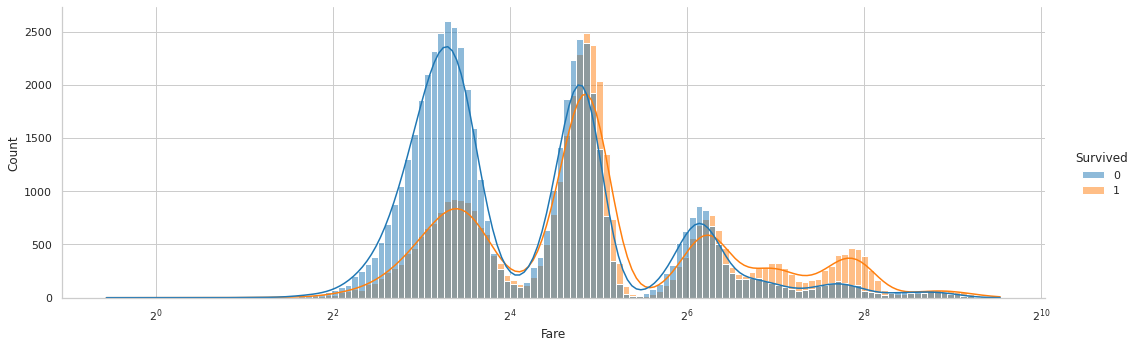

In [7]:
sns.displot(data=train, x='Age', hue='Survived', kde=True, height=5, aspect=3)
sns.displot(data=train, x='Fare', hue='Survived', log_scale=2, kde=True, height=5, aspect=3);

* На графике распределения возраста видно, что молодые люди ~ от 18 до 42 лет погибали чаще чем другие. Выживаемость среди пожилых, напротив, была выше. 
* Логарифмированный график переменной 'Fare' указывает на прямую зависимость суммы потраченой на билет и выживаемости. Пассажиры заплатившие больше 100$ выживали чаще остальных.

## 1.4 Categorical features

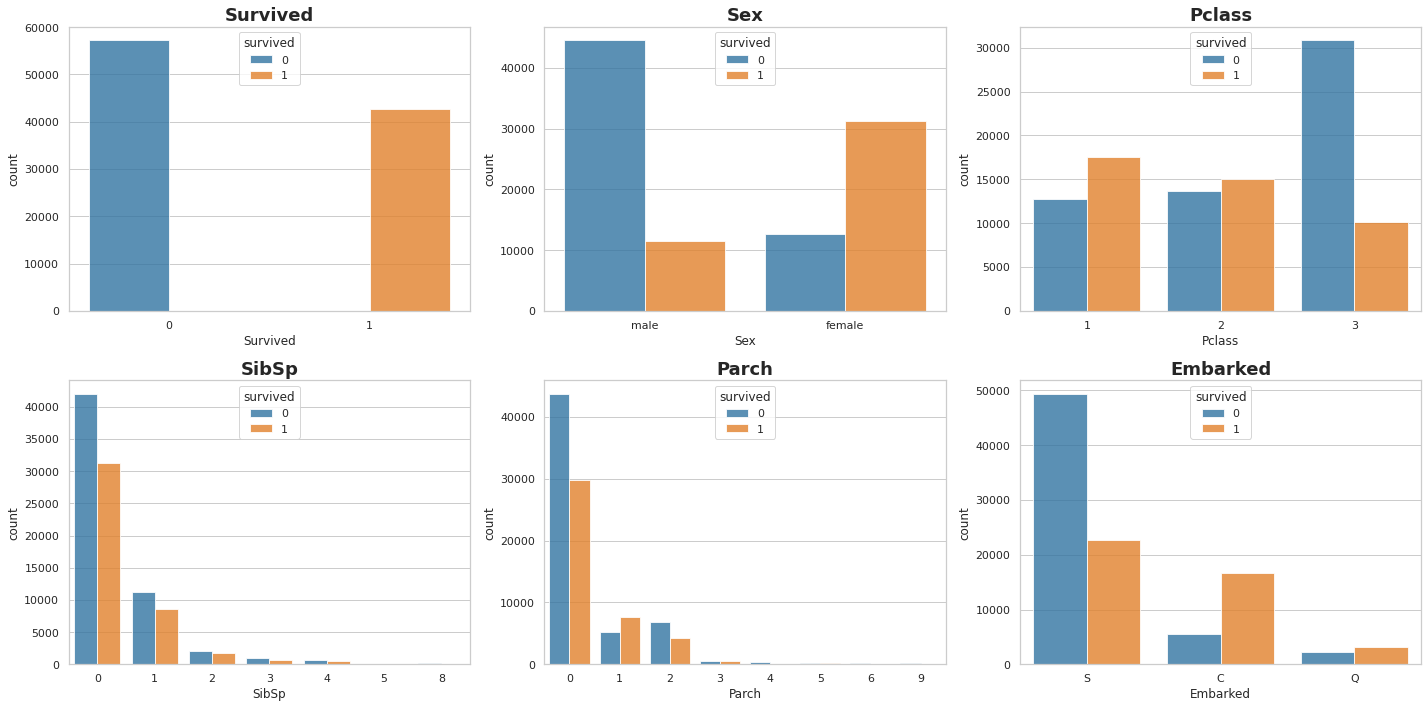

In [8]:
# определяем список категориальных переменных для которых будут строиться графики
cat_cols = ['Survived', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
# определяем кол-во столбцов, строк и создаем subplot заданного размера   
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize = (20,10))
# в цикле строим графики для каждой переменной
for i in range(rows):
    for j in range(cols):
        n = i*cols+j
        ax=axs[i][j]
        sns.countplot(data=train, x=cat_cols[n], hue='Survived', alpha=0.8, ax=ax)
        ax.set_title(cat_cols[n], fontsize=18, fontweight='bold')
        ax.legend(title="survived", loc='upper center')
plt.tight_layout()

* Sex: мужнин было больше и погибали они с большей вероятностью чем женщины.
* Psclass: У пассажиров первого класса было больше шансов выжить, люди из 3-го класса погибали чаще остальных.
* SibSp, Parch: Обе переменные указывают на кол-во родственников на борту корабля для каждого пассажира, можно сделать вывод, что путешествовать в одиночку было безопаснее. 
* Embraked: У пассажиров отправившихся из порта Cherbourg было больше всего шансов выжить.

## 1.5 Correlation matrix

In [9]:
# импорт библиотеки для построения корреляционных матриц
# https://phik.readthedocs.io/en/latest/
import phik
from phik import resources, report

In [10]:
train_for_matrix = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
thik = train_for_matrix.phik_matrix()

interval columns not set, guessing: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


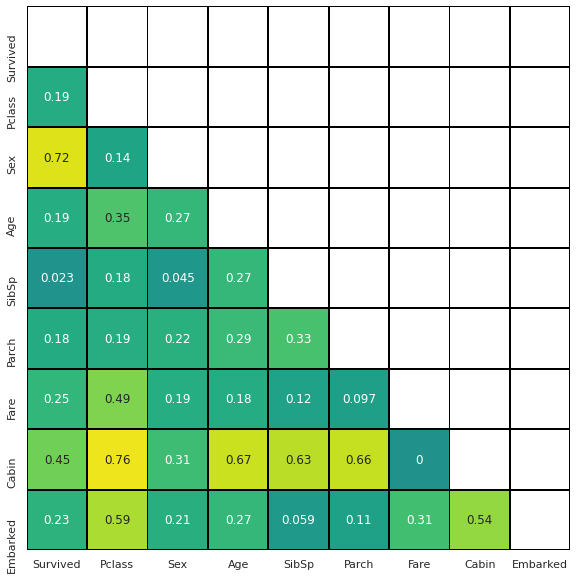

In [11]:
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(thik, dtype=np.bool))
sns.heatmap(thik, square=True, annot = True, center=0, vmax=.8, cmap='viridis', linewidths=1, linecolor='black', cbar=False, mask=mask);

* Целевая переменная 'Survived' сильнее всего коррелирует с переменной 'Sex', что подтверждает предположение о том, что женщины выживали с большей вероятностью.
* Самая сильная корреляция между 'Pclass' и 'Cabin', эту зависимость рассмотрим позже.

# 2. Data visualization: Compare Train and Test
Проведем сравнение и построим графики для train и test выборок.

## 2.1 Categorical Features

In [12]:
# объединяем Train и Test с сохранением метки к какому набору данных изначально принадлежал объект
titaniс_visual = pd.concat([train.assign(dataset='train'), test.assign(dataset='test')])

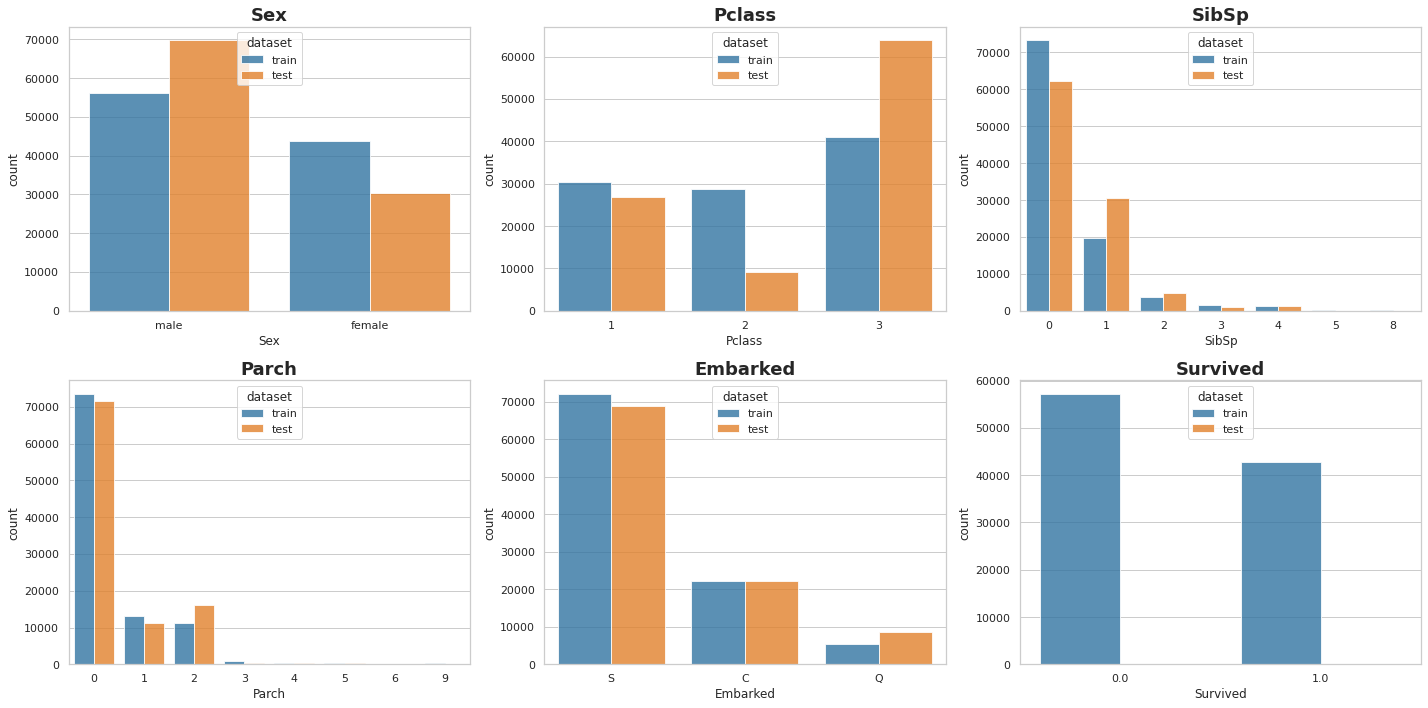

In [13]:
# определяем список категориальных переменных для которых будут строиться графики
cat_cols = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Survived']
# определяем кол-во столбцов, строк и создаем subplot заданного размера   
rows = 2
cols = 3
fig, axs = plt.subplots(rows, cols, figsize = (20,10))
# в цикле строим графики для каждой переменной
for i in range(rows):
    for j in range(cols):
        n = i*cols+j
        ax=axs[i][j]
        sns.countplot(data=titaniс_visual, x=cat_cols[n], hue='dataset', alpha=0.8, ax=ax)
        ax.set_title(cat_cols[n], fontsize=18, fontweight='bold')
        ax.legend(title="dataset", loc='upper center')
plt.tight_layout()

Размер выборок одинаковый, в обоих датасетах по 100.000 объектов.
* Sex: мужчины доминируют и в train и в test, есть лишь небольшая разница в пропорции.
* Pclass: Соотношение переменной Pclass одинаково, больше всего пассажиров путишевствовали 3-м классом, меньше 2-м. В тестовой выборке сильно меньше объектов 2-го класса.
* SibSp, Parch: в целом, значения обоих переменных распределены раномерно.

## 2.2 Numerical features

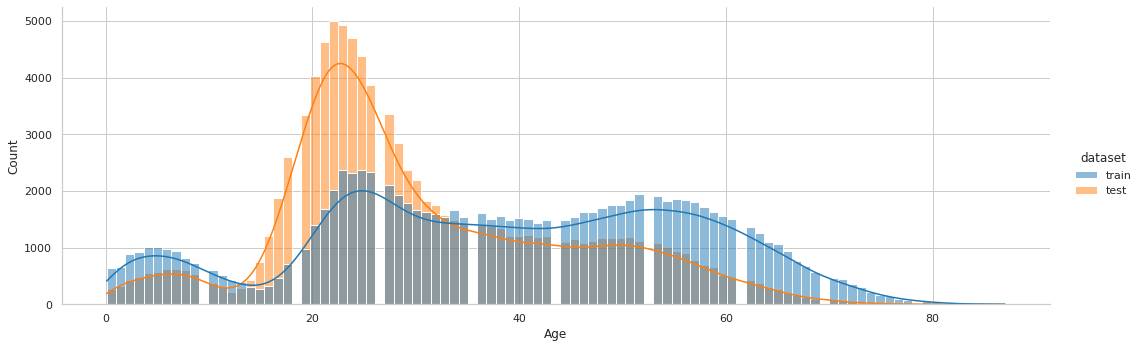

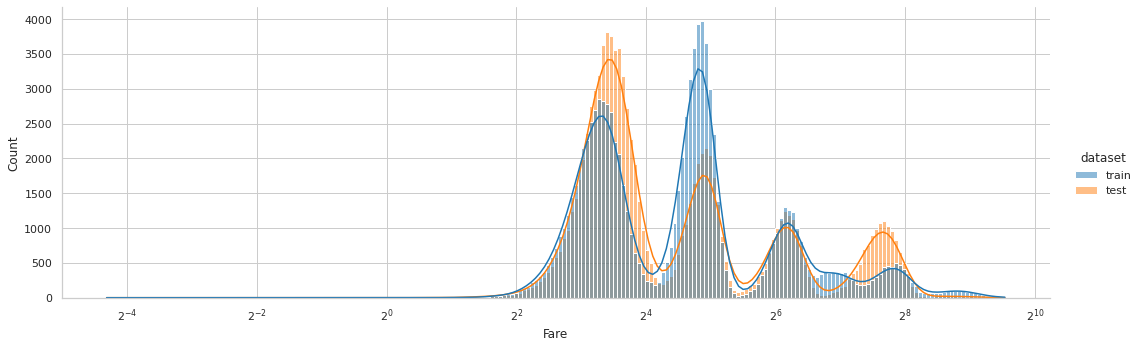

In [14]:
sns.displot(data=titaniс_visual, x='Age', hue='dataset', kde=True, height=5, aspect=3)
sns.displot(data=titaniс_visual, x='Fare', hue='dataset', log_scale=2, kde=True, height=5, aspect=3);

* Из сравнения распределений переменной 'Age' по двум выборкам, видно, что в test намного больше молодых людей ~ от 15 до 30 лет, в то-же время, в test меньше взрослых людей ~ от 40 до 80 лет. 
* Сравнительный график 'Fare' показывает, что в тестовом наборе данных больше людей заплативших больше 100$ за билет.

# 3. Feature Engineering

## 3.1 Fill empty
Заполним пропуски в каждой переменной

In [15]:
# строим таблицу пропущенных значений в данных
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(11)

,Total,Percent
Cabin,138697,0.693485
Survived,100000,0.500000
Ticket,9804,0.049020
Age,6779,0.033895
Embarked,527,0.002635
Fare,267,0.001335
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000


### Cabin
Больше всего пропусков в признаке Cabin, порядка 70% от общего кол-ва объектов. Из предыдущего соревнования известно, что в номере каюты "зашито" буквенное обозначение палубы. То, на какой палубе находилась каюта имело влияние на выживаемость. 

In [16]:
# срезаем первый символ от каждого заполненного значения, это будет номер(название) палубы
data['Deck'] = data['Cabin'].str[0]
# для незаполненных значений создаем новую категорию 'N'
data['Deck'] = data['Deck'].fillna('N')
# Cabin был заменен на Deck
data.drop('Cabin', axis=1, inplace=True)

N    138697
C     18818
B     15552
A     13519
D      6158
E      3586
F      2986
G       626
T        58
Name: Deck, dtype: int64

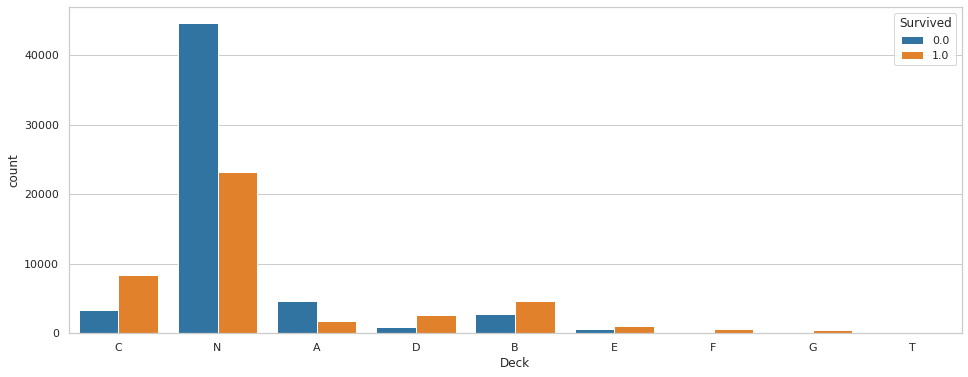

In [17]:
# смотрим на результаты
sns.countplot(x="Deck", hue='Survived', data=data);
data['Deck'].value_counts()

### Age
Поскольку корреляция между 'Age' и 'Pclass' довольно высока, заполним пропущенные значения - средним значением, для каждого пола в каждом классе.

In [18]:
# группируем по двум признакам
grp = data.groupby(['Sex', 'Pclass'])
# заполняем пропуски средним для каждой группы
data['Age'] = grp['Age'].apply(lambda x: x.fillna(x.mean()))

### Fare
У признака 'Fare' всего 267 пропущенных значений в общей выборке. Заполнять будем медианным значением для каждого 'Pclass'.

In [19]:
# группируем 
grp = data.groupby(['Pclass'])
# заполняем пропуски медианой для каждой группы
data['Fare'] = grp['Fare'].apply(lambda x: x.fillna(x.median()))

### Embarked
У Embarked 527 пропущенных значений, поскольку наблюдается сильный дисбаланс в пользу значения 'S', заполним пропуски им.

In [20]:
data['Embarked'] = data['Embarked'].fillna('S')

### Ticket
Примерно 5% пропущенных значений, зависимости от других переменных установить не удалось. Похоже, цифры в номере билета не нусут никакой информации, поэтому оставляем только буквенный индекс перед номером.

In [21]:
# от существующих значений берем сплит до первого пробела, если нет, то заполняем 'X'
data['Ticket'] = data['Ticket'].map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

In [22]:
data['Ticket'].value_counts().head(10)

X             152454
PC             17739
A.              7431
C.A.            3670
STON/O          2058
SC/PARIS        1372
A/5.            1226
PP              1173
W./C.           1088
SOTON/O.Q.      1061
Name: Ticket, dtype: int64

## 3.2 Add new Features

### Family
Признаки SibSp, Parch говорят об одном и том же, колличестве родственников на борту, поэтому объединяем два признака в один.

In [23]:
data['Family'] = data['Parch'] + data['SibSp']

### Alone
Людей путешествующих в одиночку можно выделить в отдельный признак.

In [24]:
data['Alone'] = data['Family'] == 0

### FareC
Преобразуем вещественную переменную 'Fare' в категориальную.

In [25]:
# задаем интервалы
bins = [0,10,20,25,30,65,80,110,745]
# создаем список меток для каждого интервала
lables = ['FareC-' + str(i) for i in range(len(bins)-1)]
# превращаем вещественную переменную Fare в категориальную FareC
data['FareC'] = pd.cut(data['Fare'], bins=bins, labels=lables)

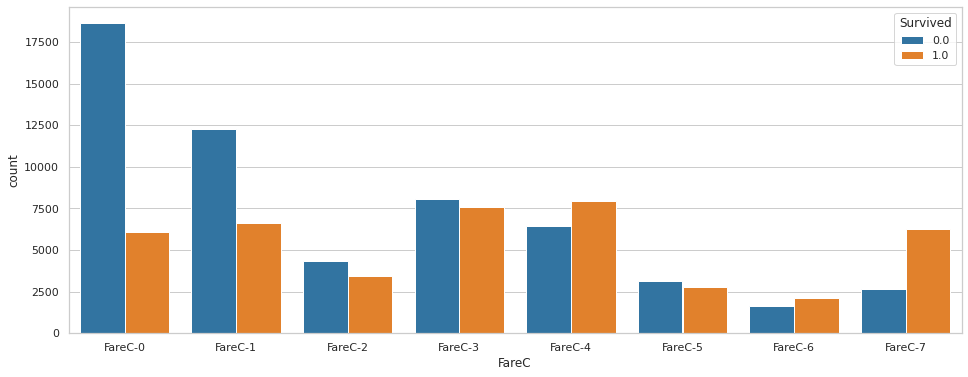

In [26]:
sns.countplot(x="FareC", hue='Survived', data=data);

### Age
Так же преобразуем переменную 'Age' в категориальную 'AgeC'.

In [27]:
# задаем интервалы
bins = [0,5,10,20,30,40,50,60,70,80,90]
# создаем список меток для каждого интервала
lables = ['AgeC-' + str(i) for i in range(len(bins)-1)]
# превращаем вещественную переменную Fare в категориальную FareC
data['AgeC'] = pd.cut(data['Age'], bins=bins, labels=lables)

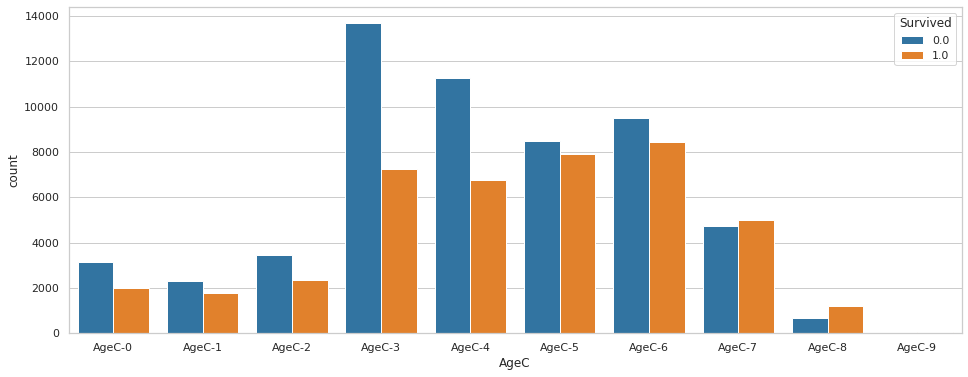

In [28]:
sns.countplot(x="AgeC", hue='Survived', data=data);

### Name
Оставим только фамилии, срезав имена

In [29]:
data['Name'] = data['Name'].apply(lambda x: str(x).split(',')[0])

In [30]:
# смотрим на 10 самых популярных фамилий
data['Name'].value_counts().head(10)

Smith       2305
Johnson     1817
Williams    1488
Brown       1352
Jones       1332
Davis       1065
Miller       905
Wilson       790
Moore        742
Thomas       724
Name: Name, dtype: int64

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   PassengerId  200000 non-null  int64   
 1   Survived     100000 non-null  float64 
 2   Pclass       200000 non-null  int64   
 3   Name         200000 non-null  object  
 4   Sex          200000 non-null  object  
 5   Age          200000 non-null  float64 
 6   SibSp        200000 non-null  int64   
 7   Parch        200000 non-null  int64   
 8   Ticket       200000 non-null  object  
 9   Fare         200000 non-null  float64 
 10  Embarked     200000 non-null  object  
 11  Deck         200000 non-null  object  
 12  Family       200000 non-null  int64   
 13  Alone        200000 non-null  bool    
 14  FareC        200000 non-null  category
 15  AgeC         200000 non-null  category
dtypes: bool(1), category(2), float64(3), int64(5), object(5)
memory usage: 20.4+ MB


После всех преобразований имеем 16 признаков, среди них есть как категориальные, так и вещественные.

In [33]:
# сохраняем измененные данные в файлы для дальнейшей работы с моделями
path = '/home/joosja/Github/My_project/tabular_playground_series_apr_2021/mod_data/'
data.to_csv(path+'data_mod.csv', index=False)